In [1]:
import os
from os.path import exists
import pickle
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K
from sklearn.model_selection import cross_val_score, KFold

import pickle
import gc
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

2022-07-18 16:25:44.092196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(os.getcwd())
os.chdir("/home/wmbio/WORK/gitworking/DeepDEP/")
print(os.getcwd())

/home/wmbio/WORK/gitworking/DeepDEP/prediction/code
/home/wmbio/WORK/gitworking/DeepDEP


In [3]:
def load_data(filename):
    data = []
    gene_names = []
    data_labels = []
    lines = open(filename).readlines()
    sample_names = lines[0].replace('\n', '').split('\t')[1:]
    dx = 1

    for line in tqdm(lines[dx:], leave=True):
        values = line.replace('\n', '').split('\t')
        gene = str.upper(values[0])
        gene_names.append(gene)
        data.append(values[1:])
    data = np.array(data, dtype='float32')
    data = np.transpose(data)

    return data, data_labels, sample_names, gene_names

def build_regressor():
    with tf.device('/cpu:0'):
        model_mut = Sequential()
        model_mut.add(Dense(1000, input_dim=premodel_mut[0][0].shape[0], activation=activation_func,
                            weights=premodel_mut[0], trainable=True))
        model_mut.add(Dense(100, input_dim=1000, activation=activation_func, weights=premodel_mut[1],
                            trainable=True))
        model_mut.add(Dense(50, input_dim=100, activation=activation_func, weights=premodel_mut[2],
                            trainable=True))

        model_exp = Sequential()
        model_exp.add(Dense(1000, input_dim=premodel_exp[0][0].shape[0], activation=activation_func,
                            weights=premodel_exp[0], trainable=True))
        model_exp.add(Dense(100, input_dim=500, activation=activation_func, weights=premodel_exp[1],
                            trainable=True))
        model_exp.add(Dense(50, input_dim=200, activation=activation_func, weights=premodel_exp[2],
                            trainable=True))

        model_cna = Sequential()
        model_cna.add(Dense(1000, input_dim=premodel_cna[0][0].shape[0], activation=activation_func,
                            weights=premodel_cna[0], trainable=True))
        model_cna.add(Dense(100, input_dim=500, activation=activation_func, weights=premodel_cna[1],
                            trainable=True))
        model_cna.add(Dense(50, input_dim=200, activation=activation_func, weights=premodel_cna[2],
                            trainable=True))

        model_meth = Sequential()
        model_meth.add(Dense(1000, input_dim=premodel_meth[0][0].shape[0], activation=activation_func,
                             weights=premodel_meth[0], trainable=True))
        model_meth.add(Dense(100, input_dim=500, activation=activation_func, weights=premodel_meth[1],
                             trainable=True))
        model_meth.add(Dense(50, input_dim=200, activation=activation_func, weights=premodel_meth[2],
                             trainable=True))

        # subnetwork of gene fingerprints
        model_gene = Sequential()
        model_gene.add(Dense(1000, input_dim=data_fprint.shape[1], activation=activation_func, kernel_initializer=init,
                             trainable=True))
        model_gene.add(Dense(100, input_dim=1000, activation=activation_func, kernel_initializer=init, trainable=True))
        model_gene.add(Dense(50, input_dim=100, activation=activation_func, kernel_initializer=init, trainable=True))

        conc = Concatenate()([model_mut.output, model_exp.output, 
                              model_cna.output, model_meth.output, model_gene.output])

        model_pre = Dense(dense_layer_dim, input_dim=250, activation=activation_func, kernel_initializer=init,
                              trainable=True)(conc)
        model_pre = Dense(dense_layer_dim, input_dim=dense_layer_dim, activation=activation_func, kernel_initializer=init,
                              trainable=True)(model_pre)
        model_pre = Dense(1, input_dim=dense_layer_dim, activation=activation_func2, kernel_initializer=init,
                              trainable=True)(model_pre)

        model_final = Model([model_mut.input, model_exp.input, model_cna.input, model_meth.input, model_gene.input], model_pre)
        
        return model_final

class generator(tf.keras.utils.Sequence):
    def __init__(self, x_mut, x_exp, x_cna, x_meth, x_fprint, y_dep, batch_size):
        self.x_mut, self.x_exp, self.x_cna, self.x_meth, self.x_fprint, self.y_dep = x_mut, x_exp, x_cna, x_meth, x_fprint, y_dep
        self.bs = batch_size
    
    def __len__(self):
        return (len(self.y_dep) - 1) // self.bs + 1
    
    def __getitem__(self,idx):
        start, end = idx * self.bs, (idx+1) * self.bs
        return (self.x_mut[start:end], self.x_exp[start:end], self.x_cna[start:end], self.x_meth[start:end], self.x_fprint[start:end]), self.y_dep[start:end]
    
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


```
# with open('prediction/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
# with open('data/ccl_complete_data_278CCL_1298DepOI_360844samples.pickle', 'rb') as f:
#     data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)
# This pickle file is for DEMO ONLY (containing 28 CCLs x 1298 DepOIs = 36344 samples)!
# First 1298 samples correspond to 1298 DepOIs of the first CCL, and so on.
# For the complete data used in the paper (278 CCLs x 1298 DepOIs = 360844 samples),
# please substitute by 'ccl_complete_data_278CCL_1298DepOI_360844samples.pickle',
# to which a link can be found in README.md
```

## **Data Load & Path**

In [4]:
TRAIN_PATH = "/home/wmbio/WORK/gitworking/DeepDEP/preprocessing/DATA/2022-07-13/"
TEMP_PATH = "prediction/train_preprocessing/"
SAVE_PATH = "prediction/custom_model/"

In [5]:
if exists("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples_custom.npz") is False:
    # load TCGA mutation data, substitute here with other genomics
    data_exp, data_labels_exp, sample_names_exp, property_names_exp = load_data(TRAIN_PATH + "train_exp_training.txt")
    if exists(TEMP_PATH + "train_exp_training.npy") is False:
        np.save(TEMP_PATH + 'train_exp_training.npy', data_exp)

    data_mut, data_labels_mut, sample_names_mut, property_names_mut = load_data(TRAIN_PATH + "train_mut_training.txt")
    if exists(TEMP_PATH + "train_mut_training.npy") is False:
        np.save(TEMP_PATH + 'train_mut_training.npy', data_mut)

    data_cna, data_labels_cna, sample_names_cna, property_names_cna = load_data(TRAIN_PATH + "train_cna_training.txt")
    if exists(TEMP_PATH + "train_cna_training.npy") is False:
        np.save(TEMP_PATH + 'train_cna_training.npy', data_cna)

    data_meth, data_labels_meth, sample_names_meth, property_names_meth = load_data(TRAIN_PATH + "train_meth_training.txt")
    if exists(TEMP_PATH + "train_meth_training.npy") is False:
        np.save(TEMP_PATH + 'train_meth_training.npy', data_meth)

    data_dep, data_labels_dep, sample_names_dep, property_names_dep = load_data(TRAIN_PATH + "train_DepScore_training.txt")
    if exists(TEMP_PATH + "train_DepScore_training.npy") is False:
        np.save(TEMP_PATH + 'train_DepScore_training.npy', data_dep)

    data_fprint, data_labels_fprint, sample_names_fprint, property_names_fprint = load_data(TRAIN_PATH + "train_fingerprint_training.txt")
    if exists(TEMP_PATH + "train_fingerprint_training.npy") is False:
        np.save(TEMP_PATH + 'train_fingerprint_training.npy', data_fprint)

    np.savez_compressed("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples_custom.npz", 
                        data_exp=data_exp, data_mut=data_mut, data_cna=data_cna, data_meth=data_meth,
                        data_dep=data_dep, data_fprint=data_fprint)
else :
    data = np.load("prediction/data/ccl_complete_data_501CCL_1298DepOI_614727samples_custom.npz")
    data_exp = data['data_exp']
    data_mut = data['data_mut']
    data_cna = data['data_cna']
    data_meth = data['data_meth']
    data_fprint = data['data_fprint']
    data_dep = data['data_dep']

## **Build Model**

* **Pretrained Model load - TCGA**

In [6]:
# Load autoencoders of each genomics that were pre-trained using 8238 TCGA samples
# New autoencoders can be pretrained using PretrainAE.py
premodel_mut = pickle.load(open(SAVE_PATH + 'premodel_tcga_custom_mut_1000_100_50.pickle', 'rb'))
premodel_exp = pickle.load(open(SAVE_PATH + 'premodel_tcga_custom_exp_1000_100_50.pickle', 'rb'))
premodel_cna = pickle.load(open(SAVE_PATH + 'premodel_tcga_custom_cna_1000_100_50.pickle', 'rb'))
premodel_meth = pickle.load(open(SAVE_PATH + 'premodel_tcga_custom_meth_1000_100_50.pickle', 'rb'))

In [7]:
activation_func = 'relu' # for all middle layers
activation_func2 = 'linear' # for output layer to output unbounded gene-effect scores
init = 'he_uniform'
dense_layer_dim = 250
batch_size = 64
num_epoch = 100
num_DepOI = 1227 # 1298 DepOIs as defined in our paper, custom 1227
num_ccl = int(data_mut.shape[0]/num_DepOI)
split_ratio = 0.8

In [8]:
# 80% CCLs for training/validation, and 20% for testing
id_rand = np.random.permutation(num_ccl)
id_cell_train = id_rand[np.arange(0, round(num_ccl * split_ratio))]
id_cell_test = id_rand[np.arange(round(num_ccl * split_ratio), num_ccl)]
id_train = np.arange(0, num_DepOI) + id_cell_train[0]*num_DepOI
for y in id_cell_train:
    id_train = np.union1d(id_train, np.arange(0, num_DepOI) + y*num_DepOI)
id_test = np.arange(0, num_DepOI) + id_cell_test[0] * num_DepOI
for y in id_cell_test:
    id_test = np.union1d(id_test, np.arange(0, num_DepOI) + y*num_DepOI)
print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
    len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))



Training/validation on 492027 samples (401 CCLs x 1227 DepOIs) and testing on 122700 samples (100 CCLs x 1227 DepOIs).




In [ ]:
# tf.keras.utils.plot_model(model_final, show_shapes=True,  show_dtype=True, to_file='model_custom.png')

## **Fit & Evaluation Model**

* **Train / Test set**

In [9]:
train_generator = generator(data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], 
                                    data_fprint[id_train], data_dep[id_train], batch_size = batch_size)

In [10]:
test_generator = generator(data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], 
                                    data_fprint[id_test], data_dep[id_test], batch_size = batch_size)

In [11]:
model = build_regressor()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=num_epoch, verbose=1,         
                    callbacks = [es])

2022-07-18 16:28:01.732923: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-18 16:28:01.752805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-18 16:28:01.812042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 16:28:01.812286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2022-07-18 16:28:01.812295: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-18 16:28:01.918611: I tensorflow/stream_executor/platform/de

Epoch 1/30
   1/7688 [..............................] - ETA: 1:11:01 - loss: 30.5654 - coeff_determination: -143.9955

2022-07-18 16:28:04.302692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


7688/7688 [==============================] - 368s 48ms/step - loss: 0.2901 - coeff_determination: -0.1246 - val_loss: 0.0611 - val_coeff_determination: 0.7650
Epoch 2/30
7688/7688 [==============================] - 360s 47ms/step - loss: 0.0619 - coeff_determination: 0.7652 - val_loss: 0.0593 - val_coeff_determination: 0.7713
Epoch 3/30
7688/7688 [==============================] - 360s 47ms/step - loss: 0.0578 - coeff_determination: 0.7794 - val_loss: 0.0586 - val_coeff_determination: 0.7735
Epoch 4/30
7688/7688 [==============================] - 360s 47ms/step - loss: 0.0567 - coeff_determination: 0.7854 - val_loss: 0.0602 - val_coeff_determination: 0.7687
Epoch 5/30
7688/7688 [==============================] - 360s 47ms/step - loss: 0.0563 - coeff_determination: 0.7874 - val_loss: 0.0581 - val_coeff_determination: 0.7753
Epoch 6/30
7688/7688 [==============================] - 360s 47ms/step - loss: 0.0556 - coeff_determination: 0.7908 - val_loss: 0.0582 - val_coeff_determination: 0.7

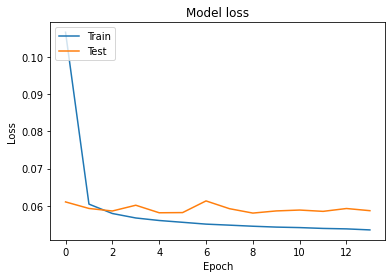

In [12]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
print("\n\nFull DeepDEP model training completed in %.1f mins.\nloss:%.4f valloss:%.4f testloss:%.4f" % (
    (time.time() - t)/60, history.model.model.history.history['loss'][history.stopped_epoch],
    history.model.model.history.history['val_loss'][history.stopped_epoch], cost_testing))

In [14]:
model.save(SAVE_PATH + "model_custom_full_0719.h5")
print("\n\nFull DeepDEP model saved in %s\n\n" % (SAVE_PATH + "model_custom_full_0719.h5"))



Full DeepDEP model saved in prediction/custom_model/model_custom_full_0719.h5




In [15]:
del model

In [16]:
gc.collect()

4111